<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/Projet/GENTIEU_GOUESSE_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : TP4


## Détection des anomalies de trajectoire

### Etape 1 : Préparation de l'environnement

Installation du projet : Sur Google Colab :
Allez dans le terminal et exécutez :
```bash
git clone https://github.com/MGentieu/Data_analytics_aircraft_messages.git
```

### On se place dans un premier temps dans le répertoire parent

In [ ]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

if cwd.name == "content": #Si vous êtes sur Colab
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "Data_analytics_aircraft_messages" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'Data_analytics_aircraft_messages' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"TP4"
else: #Si vous êtes en local, donc dans le dossier TP4. On se place alors sur le répertoire parent.
    PROJECT_ROOT = cwd.parent.resolve()

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: C:\Users\33695\Documents\Data_analytics_aircraft_messages
Setup complete.


On installe ensuite les librairies. Si vous êtes sur un environnement local, assurez-vous d'avoir un environnement virtuel activé.

Par exemple : Commandes à faire avec Windows PowerShell :
```bash
python -m venv .venv
.venv\Scripts\Activate
```

Si vous êtes sur Google Colab, pas besoin

Ensuite, que vous soyez en local ou sur colab, exécutez la cellule suivante :

In [ ]:
%pip install -r {PROJECT_ROOT/'TP4/requirements_TP4.txt'}

On importe ensuite les bibliothèques nécessaires à l'analyse :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime
import random

## PARTIE 1 : Chargement du dataset et exploration

**Objectif :** Importer les données et comprendre leur structure avant analyse.
Nous allons ici charger le fichier CSV, observer les types de données, vérifier les valeurs manquantes et analyser la distribution des anomalies.

In [3]:
df = pd.read_csv(f"{PROJECT_ROOT}/dataset_trajectoires_anomalies.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       13500 non-null  object 
 1   anomaly_type    13500 non-null  object 
 2   timestamp       13500 non-null  object 
 3   latitude        13500 non-null  float64
 4   longitude       13500 non-null  float64
 5   altitude        13500 non-null  float64
 6   ground_speed    13500 non-null  int64  
 7   vertical_speed  13500 non-null  int64  
 8   heading         13500 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 949.3+ KB


In [5]:
df.describe()

,latitude,longitude,altitude,ground_speed,vertical_speed,heading
count,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000
mean,48.666662,3.323974,6583.362470,348.859778,5.775926,180.456667
std,1.318692,1.705202,2770.046721,87.076987,463.450880,104.743477
min,45.980001,1.900000,500.000000,200.000000,-800.000000,0.000000
25%,48.500000,2.251149,5515.100671,273.000000,-392.000000,89.000000
50%,48.895973,2.567975,7887.703525,348.000000,6.000000,181.000000
75%,49.500000,3.200000,8535.910858,425.000000,406.000000,271.000000
max,50.513801,7.020000,10058.716556,500.000000,800.000000,360.000000


In [6]:
df.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159


In [ ]:
print(f"Nombre total de vols distincts : {df['flight_id'].nunique()}")

# Distribution des anomalies
anomaly_counts = df['anomaly_type'].value_counts()
print("\nDistribution des types d'anomalies :")
print(anomaly_counts)

# Visualisation rapide
plt.figure(figsize=(10, 6))
anomaly_counts.plot(kind='bar')
plt.title("Distribution des types d'anomalies")
plt.xlabel("Type d'anomalie")
plt.ylabel("Nombre d'enregistrements")
plt.xticks(rotation=45)
plt.show()

## PARTIE 2 : Extraction et visualisation d'une trajectoire brute

**Objectif :** Visualiser le chemin réellement suivi par un aéronef sélectionné.
Nous allons isoler un vol spécifique via son identifiant et tracer sa trajectoire (Latitude/Longitude) pour observer son parcours à plat.

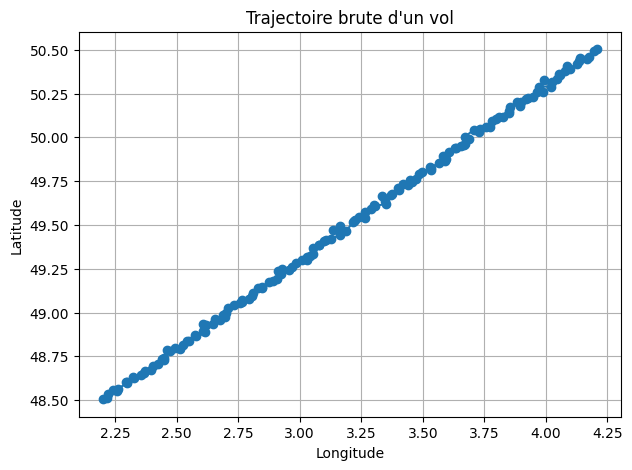

In [7]:
sample = df[df["flight_id"] == df["flight_id"].iloc[0]]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title("Trajectoire brute d'un vol")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [8]:
df["anomaly_type"].unique()


array(['Normal', 'Hijacking_Suspected', 'Sharp_Turn_Diversion',
       'Emergency_Descent', 'Holding_Pattern', 'Glider_Thermal'],
      dtype=object)

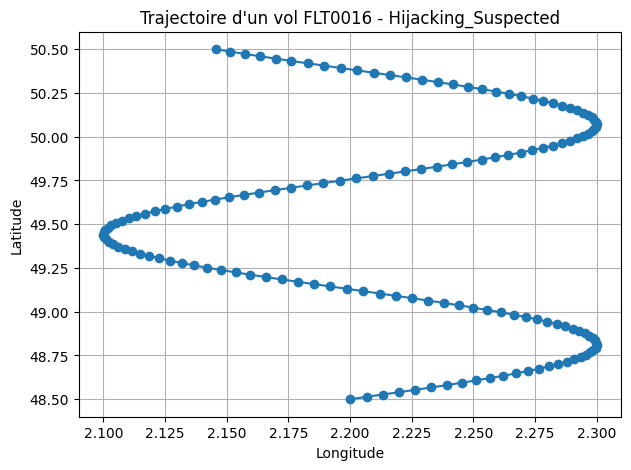

In [9]:
anomaly = "Hijacking_Suspected"

flight_id = df[df["anomaly_type"] == anomaly]["flight_id"].iloc[0]
sample = df[df["flight_id"] == flight_id]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire d'un vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

On choisit cette fois-ci une anoamlie aléatoire avec un vol aléatoire présentant cette anomalie.

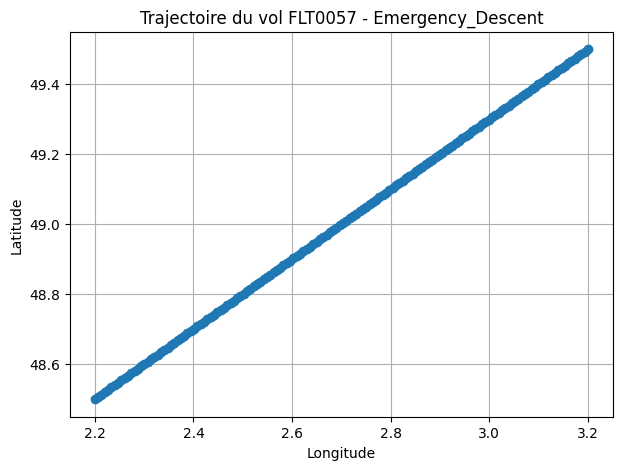

In [10]:
# 1. Sélectionner une anomalie aléatoire dans les valeurs existantes
anomaly = random.choice(df["anomaly_type"].unique())

# 2. Sélectionner un vol aléatoire contenant cette anomalie
flights_with_anomaly = df[df["anomaly_type"] == anomaly]["flight_id"].unique()
flight_id = random.choice(flights_with_anomaly)

# 3. Extraire les données du vol choisi
sample = df[df["flight_id"] == flight_id]

# 4. Plot
plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire du vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


2e tentative pour observer un résultat différent

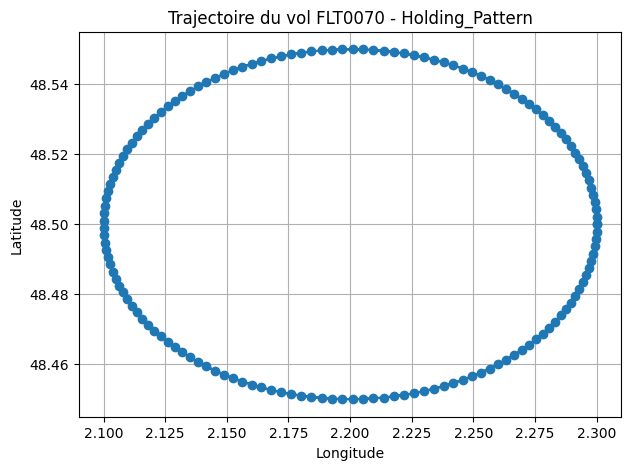

In [11]:
# 1. Sélectionner une anomalie aléatoire dans les valeurs existantes
anomaly = random.choice(df["anomaly_type"].unique())

# 2. Sélectionner un vol aléatoire contenant cette anomalie
flights_with_anomaly = df[df["anomaly_type"] == anomaly]["flight_id"].unique()
flight_id = random.choice(flights_with_anomaly)

# 3. Extraire les données du vol choisi
sample = df[df["flight_id"] == flight_id]

# 4. Plot
plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire du vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


## PARTIES 3 & 4 : Construction et décodage de la route prévue

**Objectif :** Générer une trajectoire théorique de référence.
Puisque nous n'avons pas le plan de vol officiel, nous allons simuler une "route prévue" simplifiée reliant le point de départ, le point médian et le point d'arrivée. Cette route sera ensuite convertie en une liste de points GPS exploitables pour les calculs.

In [12]:
def generate_polyline(flight_df):
  #Trier le vol en fonction des dates enregistrées.
  flight_df = flight_df.sort_values("timestamp")

  #Premier point
  lat0, long0 = flight_df.iloc[0]["latitude"], flight_df.iloc[0]["longitude"]

  #Dernier Point
  latN, longN = flight_df.iloc[-1]["latitude"], flight_df.iloc[-1]["longitude"]


  #Point médian réaliste:
  mid_idx = len(flight_df) // 2
  mid_lat, mid_long = flight_df.iloc[mid_idx]["latitude"], flight_df.iloc[mid_idx]["longitude"]
  polyline=f"{lat0},{long0};{mid_lat},{mid_long};{latN},{longN}"

  return polyline

df["intended_route_polyline"]=  (
    df.groupby("flight_id")
    .apply(generate_polyline)
    .reset_index(level=0, drop=True)
    )
df.head()

/tmp/ipython-input-607221389.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(generate_polyline)


,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading,intended_route_polyline
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172,"48.50496714153011,2.202504928503459;49.5149304..."
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54,"48.49937320902727,2.207569886166454;49.4886625..."
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228,"48.50368673308873,2.193744372984905;49.4878160..."
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163,"48.48829886973941,2.207783610761666;49.4870478..."
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159,"48.51901190685753,2.182269675317931;49.5206682..."


In [13]:
df["intended_route_polyline"]=df["intended_route_polyline"].astype(str)

def decode_polyline(polyline):
  if not isinstance(polyline, str):
    return []
  try:
    pts = polyline.split(';')
    return [tuple(map(float, p.split(','))) for p in pts]
  except:
    return []

df["route_points"]=df["intended_route_polyline"].apply(decode_polyline)
df[["intended_route_polyline", "route_points"]].head()



,intended_route_polyline,route_points
0,"48.50496714153011,2.202504928503459;49.5149304...","[(48.50496714153011, 2.202504928503459), (49.5..."
1,"48.49937320902727,2.207569886166454;49.4886625...","[(48.49937320902727, 2.207569886166454), (49.4..."
2,"48.50368673308873,2.193744372984905;49.4878160...","[(48.50368673308873, 2.193744372984905), (49.4..."
3,"48.48829886973941,2.207783610761666;49.4870478...","[(48.48829886973941, 2.207783610761666), (49.4..."
4,"48.51901190685753,2.182269675317931;49.5206682...","[(48.51901190685753, 2.182269675317931), (49.5..."


## PARTIE 5 : Calcul de la déviation

**Objectif :** Mesurer l'écart réel entre la trajectoire prévue et la trajectoire suivie.
Pour chaque point de la trajectoire réelle, nous allons calculer la distance géodésique minimale par rapport aux segments de la route théorique construite précédemment.

In [14]:
from geopy.distance import geodesic

def compute_deviation(row):
  """
  Calcule la distance minimale entre le point réel (latitude, longitude)
  et les points de la route prévue (route_points).
  Gère tous les cas d'erreurs possibles.
  """

  real_point = (row["latitude"], row["longitude"])
  route_pts = row["route_points"]

  # Cas 1 : route_points n'est pas une liste => pas de route prévue.
  if not isinstance(route_pts, list):
    return np.nan

  # Cas 2 : Liste vide => Pas de route disponible :
  if len(route_pts) == 0:
    return np.nan

  # Cas 3 : Certains éléments ne sont pas des tuples => on filtre :
  route_pts = [p for p in route_pts if isinstance(p, tuple) and len(p)==2]

  if(len(route_pts)) == 0:
    return np.nan

  # Calcul géodésique : distance point réel => chaque point prévu.
  try:
    return min(geodesic(real_point, p).meters for p in route_pts)
  except:
    return np.nan

df["deviation_m"] = df.apply(compute_deviation, axis=1)

df.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading,intended_route_polyline,route_points,deviation_m
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172,"48.50496714153011,2.202504928503459;49.5149304...","[(48.50496714153011, 2.202504928503459), (49.5...",0.000000
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54,"48.49937320902727,2.207569886166454;49.4886625...","[(48.49937320902727, 2.207569886166454), (49.4...",1567.829029
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228,"48.50368673308873,2.193744372984905;49.4878160...","[(48.50368673308873, 2.193744372984905), (49.4...",3825.643418
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163,"48.48829886973941,2.207783610761666;49.4870478...","[(48.48829886973941, 2.207783610761666), (49.4...",7902.640325
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159,"48.51901190685753,2.182269675317931;49.5206682...","[(48.51901190685753, 2.182269675317931), (49.5...",6563.653448


## PARTIE 6 : Visualisation de la déviation dans le temps

**Objectif :** Identifier visuellement les moments où le vol s'écarte de sa route.
Ce graphique permet de repérer des sauts brusques ou des dérives progressives caractéristiques de certaines anomalies (déroutements météo, pannes).

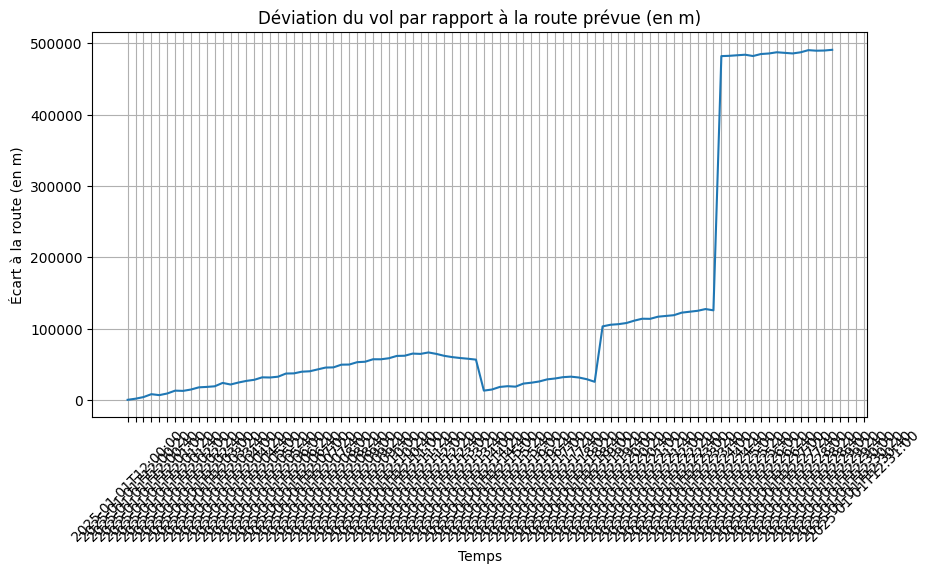

In [15]:
sample = df[df["flight_id"] == df["flight_id"].iloc[0]]

plt.figure(figsize=(10,5))
plt.plot(sample["timestamp"], sample["deviation_m"])
plt.xticks(rotation=45)
plt.title("Déviation du vol par rapport à la route prévue (en m)")
plt.xlabel("Temps")
plt.ylabel("Écart à la route (en m)")
plt.grid(True)
plt.show()

## PARTIE 7 : Classification automatique basée sur des règles

**Objectif :** Détecter automatiquement les anomalies sans Machine Learning.
Nous allons implémenter une logique métier simple basée sur des seuils de déviation (ex: > 15km) pour catégoriser les vols (Normal, Déroutement Météo, Panne Technique, etc.).

In [16]:
def classify_anomaly(row):

  if row["anomaly_type"] !="Normal":
    return row["anomaly_type"]

  if row["deviation_m"] > 15000:
    return "Technical issue"

  if 3000 < row["deviation_m"] <= 15000:
    return "Weather_Diversion"

  return "Normal"

df["auto_label"] = df.apply(classify_anomaly, axis=1)
df[["anomaly_type", "auto_label"]].head()

,anomaly_type,auto_label
0,Normal,Normal
1,Normal,Normal
2,Normal,Weather_Diversion
3,Normal,Weather_Diversion
4,Normal,Weather_Diversion


## PARTIE 8 : Analyse du pilote automatique

**Objectif :** Détecter les comportements suspects associés à l'état du pilote automatique.
Nous simulons ici l'état du pilote automatique (ON/OFF) en fonction des phases de vol et des types d'anomalies critiques (comme les détournements) pour voir si des corrélations existent.

In [20]:
def generate_autopilot_for_flight(flight_df):
  n = len(flight_df)
  autopilot =[]

  # Si situation critique
  for i in range(n):
    if flight_df.iloc[i]["anomaly_type"] in [
        "Hijacking_Suspected",
        "Sharp_Turn_Diversion",
        "Emergency_Descent"
    ]:
      autopilot.append(0)
      continue

    # avant 10% du vol : Décollage
    if i < n *0.10:
      autopilot.append(0)
      continue

    # après 90% du vol : Atterrissage
    if i > n*0.90:
      autopilot.append(0)
      continue

    autopilot.append(1)

  return autopilot

df["autopilot_on"] = df.groupby("flight_id").apply(
    lambda g : generate_autopilot_for_flight(g)
).explode().values
df[["flight_id", "autopilot_on"]].head()

/tmp/ipython-input-2841161722.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["autopilot_on"] = df.groupby("flight_id").apply(


,flight_id,autopilot_on
0,FLT0001,0
1,FLT0001,0
2,FLT0001,0
3,FLT0001,0
4,FLT0001,0


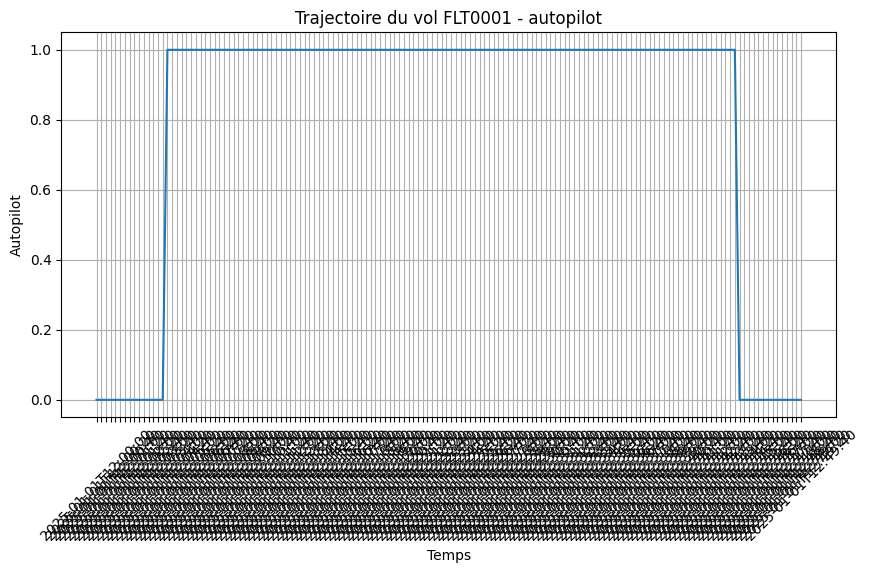

In [24]:
flight_id = df["flight_id"].iloc[0]
sample = df[df["flight_id"] == flight_id]

plt.figure(figsize=(10,5))
plt.plot(sample["timestamp"], sample["autopilot_on"])
plt.xticks(rotation=45)
plt.title(f"Trajectoire du vol {flight_id} - autopilot")
plt.xlabel("Temps")
plt.ylabel("Autopilot")
plt.grid(True)
plt.show()

## PARTIES 9 & 10 : Regroupement par vol et Détection d'intrusions

**Objectif :** Préparer les données pour l'analyse globale et vérifier les infractions géographiques.
Nous définissons une zone d'exclusion rectangulaire (ex: zone militaire ou urbaine sensible) et marquons les points de trajectoire qui pénètrent dans cette zone.

In [25]:
restricted_zone = [(48.5, 2.2), (48.7, 2.2), (48.7, 2.4), (48.5, 2.4)]

def in_restricted(lat, lon):
  return 48.5 <= lat <= 48.7 and 2.2 <= lon <= 2.4

df["illegal_zone"] = df.apply(lambda r: in_restricted(r["latitude"], r["longitude"]), axis=1)

df["illegal_zone"].value_counts()

,count
illegal_zone,
False,11804
True,1696


## PARTIE 11 : Construction d'un modèle de classification automatique (Machine Learning)

**Objectif :** Entraîner une IA à reconnaître les types d'anomalies.
Nous allons utiliser un algorithme de Random Forest.
1. **Préparation :** Sélection des features (vitesse, altitude, déviation, autopilot, zone interdite, etc.) et encodage des labels.
2. **Entraînement :** Split Train/Test et fit du modèle.
3. **Évaluation :** Rapport de classification pour mesurer la précision du modèle.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df_ml = df[[
    "latitude", "longitude", "altitude", "ground_speed", "vertical_speed",
    "heading", "autopilot_on", "deviation_m", "anomaly_type"
]].dropna()

lbl = LabelEncoder()
df_ml["anomaly_type"] = lbl.fit_transform(df_ml["anomaly_type"])

X = df_ml.drop("anomaly_type", axis=1)
y = df_ml["anomaly_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

